# Preprocessing and visualization of Dataset #1: Adults

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors

In [52]:
# 1. Load the datasets into Pandas dataframes
names1=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'over-50K']
dataset1_train = pd.read_csv('adult_train.csv', index_col=False, names=names1, sep=',\s', na_values=['?'], engine='python')
dataset1_test = pd.read_csv('adult_test.csv', index_col=False, names=names1, sep=',\s', na_values=['?', 'nan', '|1x3 Cross validator'], engine='python')


# Split data
x_train, x_test, y_train, y_test = train_test_split(dataset1_train, dataset1_train['over-50K'], test_size=0.15, shuffle=True)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)
print(dataset1_train.shape)

(27676, 15) (4885, 15)
(27676,) (4885,)
(32561, 15)


## Clean the data

In [34]:
# Remove instances with missing/invalid data entries
dataset1_train.dropna(axis=0, how='any', inplace=True)
dataset1_test.dropna(axis=0, how='any', inplace=True)
print(dataset1_train.shape)

(30162, 15)


In [35]:
# Encode Over 50K as 1
dataset1_train['over-50K'] = dataset1_train['over-50K'].map({'>50K': 1, '<=50K': 0})
dataset1_test['over-50K'] = dataset1_test['over-50K'].map({'>50K': 1, '<=50K': 0})

# Encode Male as 1
dataset1_train['sex'] = dataset1_train['sex'].map({'Male': 1, 'Female': 0})
dataset1_test['sex'] = dataset1_test['sex'].map({'Male': 1, 'Female': 0})

In [36]:
print(dataset1_train['native-country'].describe()) 

count             30162
unique               41
top       United-States
freq              27504
Name: native-country, dtype: object


Since 91% of native-country data is US, we will categorize this column as "US" and "non-US".

In [38]:
# Encode US as 1 and non-US as 0
dataset1_train['native-country'] = np.where(dataset1_train['native-country']=='United-States', 1, 0)
dataset1_test['native-country'] = np.where(dataset1_test['native-country']=='United-States', 1, 0)

In [7]:
# Correlation
correlations = dataset1_train.corr(method="pearson")

From the above correlations, we can interpret that 'fnlgwt' and 'native-country' are not relevant to predicting the salary as their correlation is below 0.09.

In [39]:
# Remove uncorrelated columns
dataset1_train = dataset1_train.drop(columns=['fnlwgt', 'native-country'])
dataset1_test = dataset1_test.drop(columns=['fnlwgt', 'native-country'])

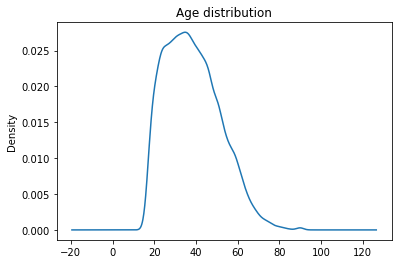

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'education-num'}>,
        <AxesSubplot:title={'center':'sex'}>],
       [<AxesSubplot:title={'center':'capital-gain'}>,
        <AxesSubplot:title={'center':'capital-loss'}>,
        <AxesSubplot:title={'center':'hours-per-week'}>],
       [<AxesSubplot:title={'center':'over-50K'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

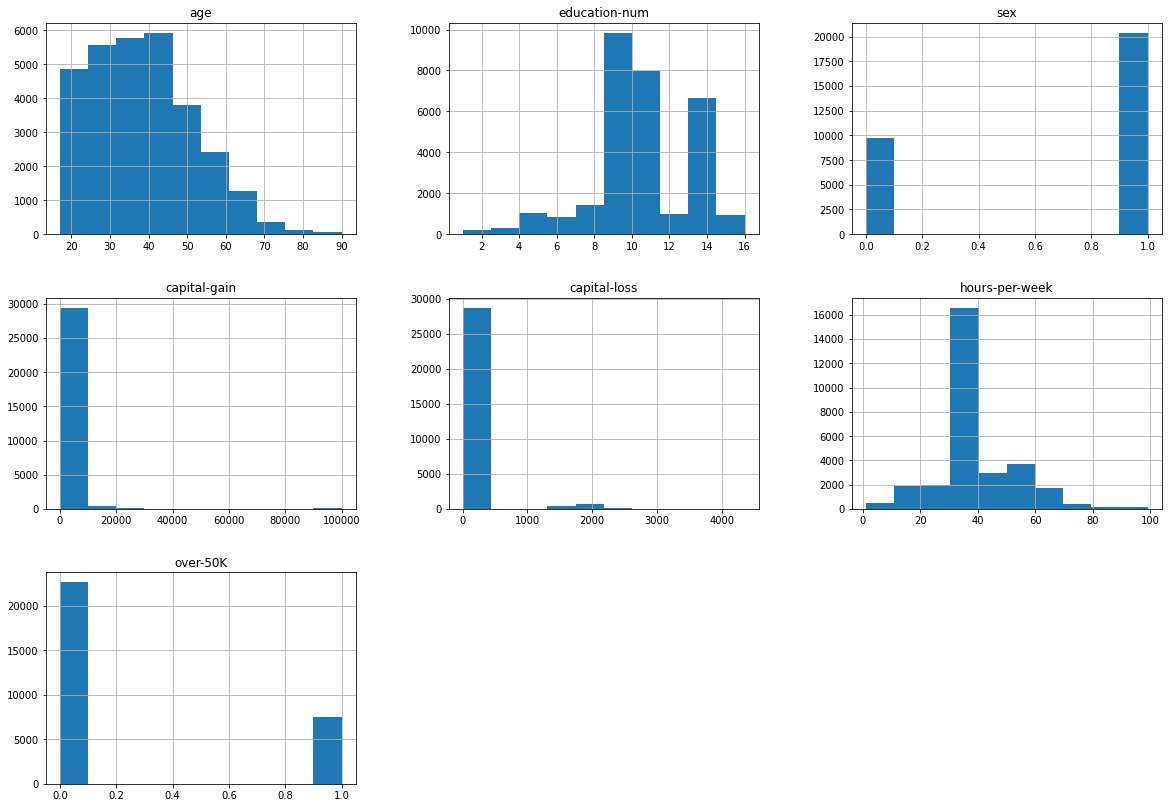

In [9]:
# Visualize age distribution
dataset1_train.age.plot(kind='kde')
plt.title('Age distribution')
plt.show()

# Visualize all numerical categories
dataset1_train.hist(figsize=(20, 14))

In [40]:
# Visualize categorical data
dataset1_train['education'].value_counts()
pd.crosstab(dataset1_train['education-num'], columns=dataset1_train['education'])
print(dataset1_train.shape)

# Remove education-num as it gives no more information than education
dataset1_train = dataset1_train.drop(columns='education-num')
dataset1_test = dataset1_test.drop(columns='education-num')
print(dataset1_train.shape)

(30162, 13)
(30162, 12)


## One-hot encoding

In [41]:
import category_encoders as ce

# Convert discrete variables into multiple variables using one-hot encoding
# Discrete columns: workclass, education, marital-status, occupation, relationship, sex, native-country
encoder = ce.OneHotEncoder(cols=['workclass', 'education', 'marital-status', 'occupation', 'race', 'relationship'], use_cat_names=True)
train_encoded_1 = encoder.fit_transform(dataset1_train)
test_encoded_1 = encoder.transform(dataset1_test) 

names_1_encoded = train_encoded_1.columns

/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [42]:
# Normalize
from sklearn import preprocessing

# Normalize training set
x = train_encoded_1.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_dataset_1 = pd.DataFrame(x_scaled, columns=names_1_encoded)

# Normalize test set
x = test_encoded_1.values
x_scaled = min_max_scaler.fit_transform(x)
normalized_dataset_1_test = pd.DataFrame(x_scaled, columns=names_1_encoded)

/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


# Experiments


## Cross Validation

In [43]:
def cross_validate(n, n_folds=5):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

## KNN

In [50]:
(num_instances, num_features) = dataset1_train.shape

x_train = normalized_dataset_1.iloc[:,:-1]
y_train = normalized_dataset_1.iloc[:,-1:]
x_test =normalized_dataset_1_test.iloc[:,:-1]
y_test = normalized_dataset_1_test.iloc[:,-1:]

#Data split
# n_test = num_instances // 5
# inds = np.random.permutation(num_instances)
# x_train, y_train = x[inds[n_test:]], y[inds[n_test:]]
# x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
# inds = np.random.permutation(num_instances)
# x_train = normalized_dataset_1.drop(['over-50K'], axis=1) # drop column about over or under-50K (salary)
# y_train = normalized_dataset_1['over-50K']
# x_test = normalized_dataset_1.drop(['over-50K'], axis=1) # drop column about over or under-50K (salary)
# y_test = normalized_dataset_1['over-50K']

loss = lambda y, yh: np.mean((y-yh)**2)

#Plot the mean square error for different K values stored in K_list
K_list = range(1,30)
err_train, err_test = [], []
for i, K in enumerate(K_list):
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    model = model.fit(x_train, y_train)
    err_test.append(loss(model.predict(x_test), y_test))
    err_train.append(loss(model.predict(x_train), y_train))

plt.plot(K_list, err_test, '-', label='unseen')
plt.plot(K_list, err_train, '-', label='train')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()

KeyboardInterrupt: 

## Decision Tree